In [1]:
import pandas as pd 
import numpy as np 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import cross_val_predict, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
wbt = pd.read_csv('./my_datasets/wbt_genre_text.csv')

In [3]:
wbt.head()

,genre,text
0,1,In the beginning God created the heaven and th...
1,1,"And the earth was without form, and void; and ..."
2,1,"And God said, Let there be light: and there wa..."
3,1,"And God saw the light, that it was good: and G..."
4,1,"And God called the light Day, and the darkness..."


# Visualize the count of the 8 classes 

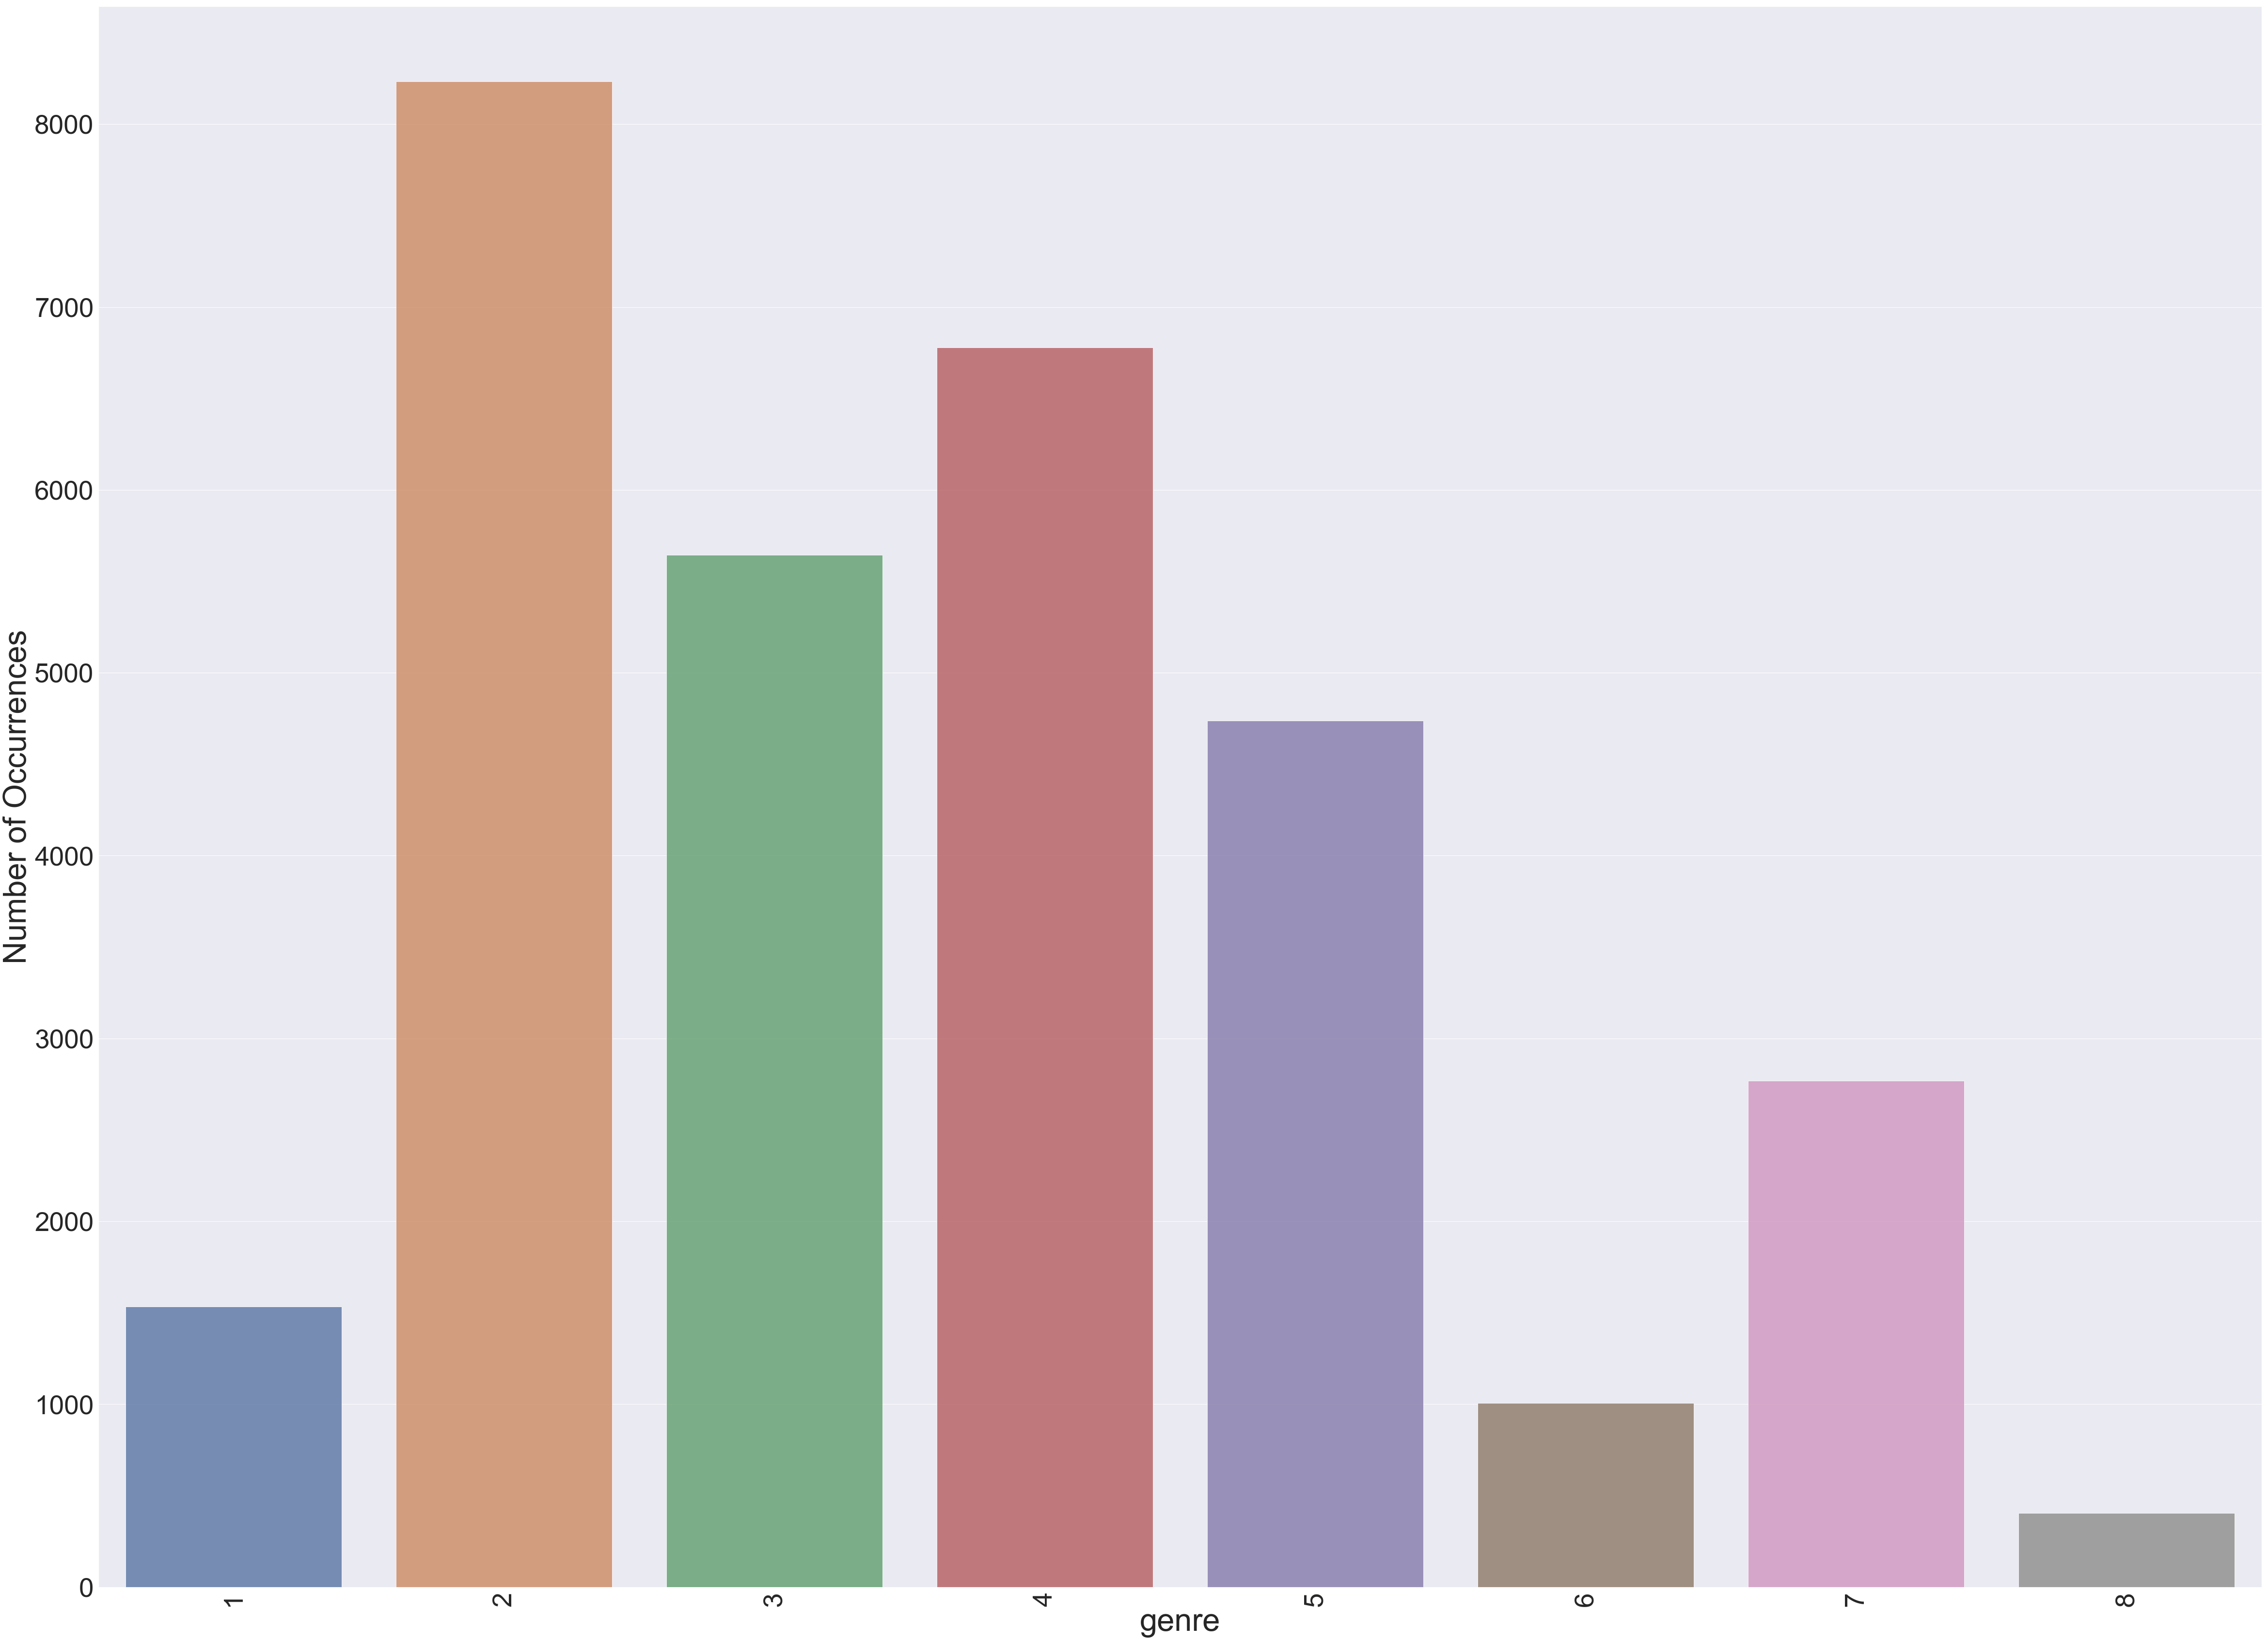

In [7]:
sns.set(font_scale=5)

cnt_pro =wbt['genre'].value_counts()
plt.figure(figsize=(80,60))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=65)
plt.xlabel('genre', fontsize=65)
plt.xticks(rotation=90)
plt.show();

# Train/test split 

In [9]:
X = wbt['text']
y = wbt['genre']

print(X.shape)
print(y.shape)

(31106,)
(31106,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=51619,
                                                   stratify=y)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23329,), (7777,), (23329,), (7777,))

# Simple TFIDF and Logistic Regression baseline score before parameter tuening


In [12]:
tf = TfidfVectorizer(stop_words = 'english')

In [13]:
pipe = Pipeline([
        ('tf', TfidfVectorizer()),
        ('lr', LogisticRegression())
    ])

In [14]:
cross_val_score(pipe, X_train, y_train, cv=5).mean() 

/Users/mekdes/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mekdes/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.7003307834383672

In [15]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [16]:
pipe.score(X_train, y_train)

0.7840456084701445

In [17]:
pipe.score(X_test, y_test) 

0.7148000514337148

# TFIDF parameter tuening 

In [18]:
def scale_model_evaluate(X, y, model_name='lr', 
                         tokenizer_name='tfidf', 
                         tokenizer = TfidfVectorizer(),
                       model_type=LogisticRegression(), 
                       parameters={'tfidf__max_df': [.1, .2],
                                   'tfidf__min_df': [.09, 1],
                                   'tfidf__ngram_range': (1.3, 1),
                                   'lr__penalty': ['l1', 'l2'],
                                   'lr__C': np.logspace(0, 5, 10),
                                   'lr__penalty': ['l1', 'l2'],
                                   'lr__C': np.logspace(0, 5, 10),
                                   'lr__n_jobs': [1], 
                                  }
                        ):
 
    
    pipe=Pipeline(memory=None,
         steps=[(tokenizer_name,tokenizer),
                (model_name,model_type)])
                         
 
    grid = GridSearchCV(pipe, param_grid=parameters, cv=5)
    grid = grid.fit(X, y) 
    
    
    
    
    print(f"For model: {model_type}")
    print(f"The best parameters are: {grid.best_params_}")
    print(f"The best score is: {grid.best_score_:.2f}")
    return grid

In [19]:
scale_model_evaluate(X_train, y_train, 
                     model_name='lr', 
                     tokenizer_name='tfidf',
                     tokenizer = TfidfVectorizer(),
                     parameters={'tfidf__max_df': [.1, .2],
                                 'tfidf__min_df': [.09, 1],
                                 'tfidf__ngram_range':[(1, 1), (1, 2)],
                                 'lr__penalty': ['l1', 'l2'],
                                 'lr__n_jobs': [1]
                                } )

/Users/mekdes/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mekdes/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


For model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
The best parameters are: {'lr__n_jobs': 1, 'lr__penalty': 'l2', 'tfidf__max_df': 0.1, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
The best score is: 0.70


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'tfidf__max_df': [0.1, 0.2], 'tfidf__min_df': [0.09, 1], 'tfidf__ngram_range': [(1, 1), (1, 2)], 'lr__penalty': ['l1', 'l2'], 'lr__n_jobs': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

# Multinomial NB and TFIDF 

In [21]:
pipe = Pipeline([
        ('tf', TfidfVectorizer()),
        ('nb', MultinomialNB())
    ])

In [22]:
cross_val_score(pipe, X_train, y_train, cv=5).mean() 

0.6221020474674798

In [23]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...True,
        vocabulary=None)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [24]:
pipe.score(X_train, y_train)

0.6941574863903296

In [25]:
pipe.score(X_test, y_test) 

0.6357207149286357

# Doc-2-vec 

Source : https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

In [26]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk 
from nltk.corpus import stopwords 

# Train/test split 

In [27]:
train, test = train_test_split(wbt, test_size=0.3, random_state=1519)

In [28]:
text = wbt['text']
genre = wbt['genre']

# Tokenize text 

In [30]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.genre]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.genre]), axis=1)

In [31]:
train_tagged.values[1000]

TaggedDocument(words=['wherefore', 'the', 'king', 'hearkened', 'not', 'to', 'the', 'people', 'for', 'the', 'cause', 'was', 'from', 'the', 'lord', 'that', 'he', 'might', 'perform', 'his', 'saying', 'which', 'the', 'lord', 'spoke', 'by', 'ahijah', 'the', 'shilonite', 'to', 'jeroboam', 'the', 'son', 'of', 'nebat'], tags=[2])

# Assigning multi processing cores 

In [32]:
import multiprocessing

cores = multiprocessing.cpu_count()

In [33]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 21774/21774 [00:00<00:00, 2491862.90it/s]


In [34]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 21774/21774 [00:00<00:00, 3155183.12it/s]


CPU times: user 42 s, sys: 8.32 s, total: 50.4 s
Wall time: 26.6 s


# Building the final vector feature for the classifier 

In [35]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [36]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [37]:
lr = LogisticRegression(n_jobs=1, C=1e5)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

/Users/mekdes/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mekdes/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [38]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))


Testing accuracy 0.29232747535362197
Testing F1 score: 0.24325515840536016


/Users/mekdes/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Distributed memory averaging 

In [39]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 21774/21774 [00:00<00:00, 2509735.78it/s]


In [40]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 21774/21774 [00:00<00:00, 2975782.84it/s]


CPU times: user 1min 4s, sys: 18.4 s, total: 1min 22s
Wall time: 44.3 s


# Train Logistic Regression 

In [41]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

/Users/mekdes/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mekdes/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing accuracy 0.4484569224174882
Testing F1 score: 0.45595600964375327


In [42]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [43]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

# Building feature vectors 

In [44]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [45]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)

In [46]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

/Users/mekdes/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mekdes/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing accuracy 0.4370981568795542
Testing F1 score: 0.4499184400319295
